# Tropics Temperature Quantile Theory
Looks at how Theory 4 does at predicted quantiles of temperature extremes in the tropics

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm

2023-02-17 11:03:36,713 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE
pressure_ft = 500                             # only keep surface and free troposphere pressure values
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 2
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f'k={tau_lw_ref}', f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
evap_param = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=[pressure_ft, np.inf], method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    try:
        evap_param += [namelist['surface_flux_nml']['land_evap_prefactor']]
    except KeyError:
        print(f'Experiment {i}: Evap param not specified so set to default value of 1')
        evap_param += [1]


Experiment 0: Evap param not specified so set to default value of 1
Experiment 1: Evap param not specified so set to default value of 1


## Get datasets
Get one dataset, `ds_quant`, for ocean, for each latitude bin averaged over all days exceeding a given percentile in near surface air temperature.

Get another dataset, `ds_summer`, which is averaged over the ocean summer for a given latitude bin.

In [66]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 30
# lat_max = 60

ds_summer = []
ds_all = {'ocean': []}

with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
        ds_all['ocean'] += [ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))]
        ds_all['ocean'][i].load()

        ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [6, 7, 8]).sel(lat=slice(lat_min, lat_max))    # NH summer is JJA
        ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [12, 1, 2]).sel(lat=slice(-lat_max, -lat_min))    # SH summer is DJF
        # Combine hemispheres and average over longitude, time and latitude.
        ds_use = xr.concat([ds_nh_summer, ds_sh_summer], dim='lat')
        ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        ds_summer += [ds_use]
        ds_summer[i].load()
        pbar.update(1)

100%|██████████| 2/2 [00:27<00:00, 13.74s/it]


## Temperature Percentile
Recreating Figure 2 of Byrne 2021.

In [67]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
def get_quant_ind(dataset, percentile):
    # Function to find indices in dataset corresponding to surface temperature above a given quantile
    quantile_thresh = dataset.temp[-1].quantile(percentile/100, dim='lon_lat_time', keep_attrs=True)
    quant_ind = np.where(dataset.temp[-1] > quantile_thresh)[0]
    return quant_ind

surfaces = ['ocean']
n_surf = len(surfaces)
quant_plot = np.arange(100)     # first value must be 0 so temp_quant[0] is the mean value
n_quant = len(quant_plot)

# surface values
temp_quant = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
sphum_quant = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
z_quant = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}

# free troposphere values
temp_quant_ft = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
sphum_quant_ft = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
z_quant_ft = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}

with tqdm(total=n_exp*n_quant*n_surf, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j, quant in enumerate(quant_plot):
            for k, ds_use in enumerate([ds_all['ocean']]):
                use_ind = get_quant_ind(ds_use[i], quant)
                temp_quant[surfaces[k]][i, j] = np.mean(ds_use[i].temp[-1][use_ind])
                sphum_quant[surfaces[k]][i, j] = np.mean(ds_use[i].sphum[-1][use_ind])
                z_quant[surfaces[k]][i, j] = np.mean(ds_use[i].height[-1][use_ind])

                temp_quant_ft[surfaces[k]][i, j] = np.mean(ds_use[i].temp[0][use_ind])
                sphum_quant_ft[surfaces[k]][i, j] = np.mean(ds_use[i].sphum[0][use_ind])
                z_quant_ft[surfaces[k]][i, j] = np.mean(ds_use[i].height[0][use_ind])
                pbar.update(1)

temp_mean = {surf: np.asarray([temp_quant[surf][i][0] for i in range(n_exp)]) for surf in surfaces}

100%|██████████| 200/200 [00:24<00:00,  8.20it/s]


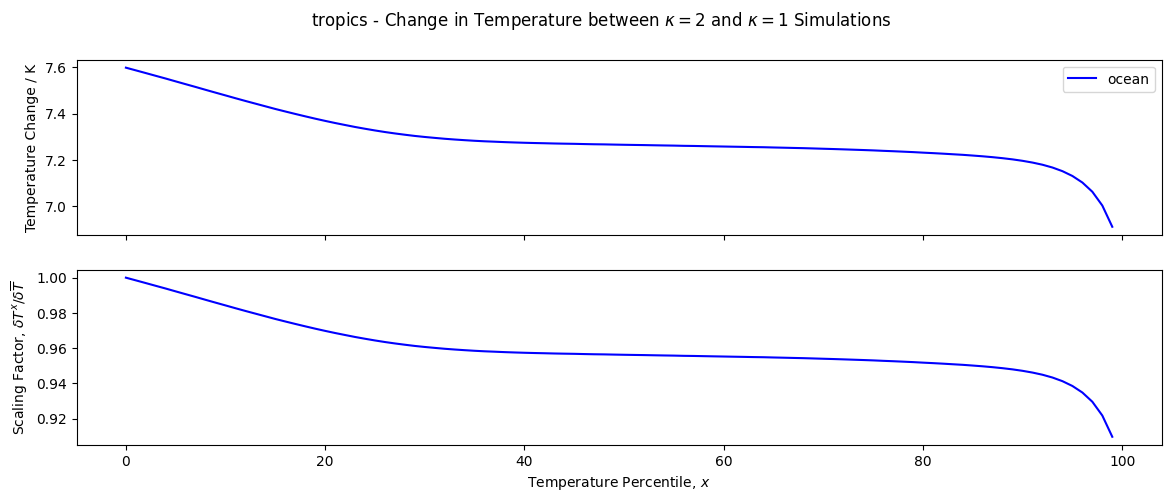

In [68]:
# Plot temperature change vs percentile
plt_color = {'land': 'red', 'ocean': 'blue'}
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
for surf in ['ocean']:
    temp_diff_quant = temp_quant[surf][1]-temp_quant[surf][0]
    temp_diff_mean = temp_mean[surf][1]-temp_mean[surf][0]
    ax[0].plot(quant_plot, temp_diff_quant, label=surf, color=plt_color[surf])
    ax[1].plot(quant_plot, temp_diff_quant/temp_diff_mean, label=surf, color=plt_color[surf])
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].legend()
plt.suptitle(f"{region} - Change in Temperature between $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations");

## Moist Static Energy
The assumption of quasi convective equilibrium says that $\delta h_x = \delta \overline{h}$ i.e. the change in MSE on the $x$ percentile temperature day is equal to that on the mean, $x=0$, day. This is saying that both the mean and $x$ percentile day can differ from convective neutral profile but that this difference remains constant as the climate warms.

The bottom left plot below indicate that for the hottest days over ocean, $\delta h_x$ is significantly larger than $\delta \overline{h}$, indicating that this may break down.

The right plots show that in the free troposphere, over ocean, the MSE decreases for the highest surface temperature percentiles. The free troposphere saturated MSE only depends on free troposphere temperature, so this indicates that the free troposphere temperature does not increase in relation to the surface temperature as we may expect. This then means that the temperature profile must differ as $x$ changes.

In [69]:
p_surface = float(ds_summer[0].pfull[-1]) * 100  # pressure where surface temperature is computed - same for all ds

def sphum_sat(temp, pressure):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure)
    q_sat = w_sat / (1+w_sat)
    return q_sat

def clausius_clapeyron_factor(temp):
    # Alpha in byrne 2021
    return L_v / (R_v * temp**2)

mse = {surf: np.asarray([moist_static_energy(temp_quant[surf][i], sphum_quant[surf][i], z_quant[surf][i]) for i in range(n_exp)])
       for surf in surfaces}
mse_ft = {surf: np.asarray([moist_static_energy(temp_quant_ft[surf][i],
                                                sphum_quant_ft[surf][i], z_quant_ft[surf][i])
                            for i in range(n_exp)]) for surf in surfaces}
mse_ft_sat = {surf: np.asarray([moist_static_energy(temp_quant_ft[surf][i],
                                                sphum_sat(temp_quant_ft[surf][i], pressure_ft*100), z_quant_ft[surf][i])
                            for i in range(n_exp)]) for surf in surfaces}

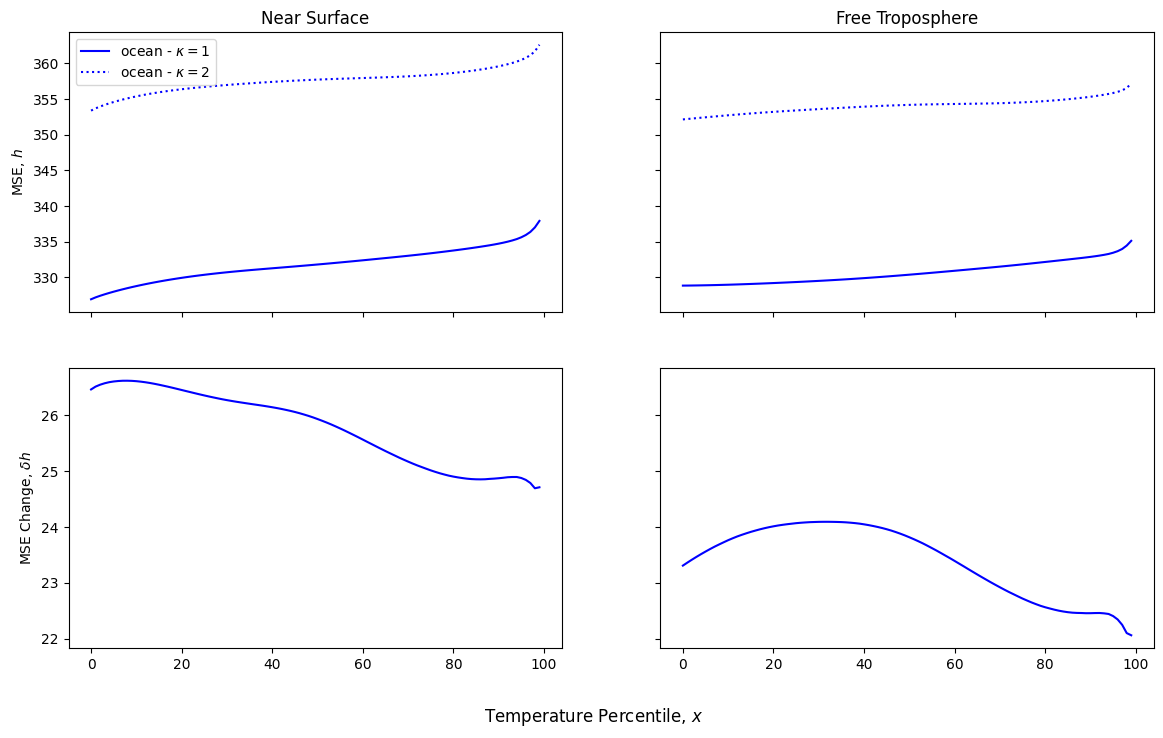

In [70]:
fig, ax = plt.subplots(2,2, figsize=(14, 8), sharex=True, sharey='row')
for surf in surfaces:
    ax[0,0].plot(quant_plot, mse[surf][0], color=plt_color[surf], label=f'{surf} - $\kappa={tau_lw_ref}$')
    ax[0,0].plot(quant_plot, mse[surf][1], color=plt_color[surf], linestyle=':', label=f'{surf} - $\kappa={tau_lw_warm}$')
    ax[0,1].plot(quant_plot, mse_ft_sat[surf][0], color=plt_color[surf], label=surf)
    ax[0,1].plot(quant_plot, mse_ft_sat[surf][1], color=plt_color[surf], label=surf, linestyle=':')

    ax[1,0].plot(quant_plot, mse[surf][1] - mse[surf][0], color=plt_color[surf])
    ax[1,1].plot(quant_plot, mse_ft_sat[surf][1] - mse_ft_sat[surf][0], color=plt_color[surf])
#ax.plot(quant_plot, mse['ocean'][1]-mse['ocean'][0], color='blue', label='Simulated $\delta h_x$')
# ax.plot(lat_centre, mse_quant_diff_sim, color='k', linestyle='--', label='Theory $\delta h_x$')
# ax.plot(lat_centre, mse_summer_diff, color='r', linestyle=':', label='Mean, $\delta \overline{h}$')
fig.supxlabel('Temperature Percentile, $x$')
ax[0,0].set_ylabel(f'MSE, $h$')
ax[0,0].set_title(f'Near Surface')
ax[0,1].set_title(f'Free Troposphere')
ax[1,0].set_ylabel(f'MSE Change, $\delta h$')
ax[0,0].legend();

Another theory is that $\delta h_x = \delta \overline{h} + \delta \Delta h^*_{x,FT}$. This is saying that as the climate warms, both the mean and $x$ percentile day, can vary their difference from convective neutrality by an amount $\delta \epsilon$ but that this amount must be the same for the mean and $x$ percentile day.

The plots below investigate this theory (4) and the quasi convective neutrality theory (3).

If we take the mean day to be that over ocean (bottom left plot), then we see that theory 4 captures the broad trend of $\delta h$ with $x$ over land and matches it especially well at large $x$.

Over ocean, we see that theory 4 predicts the complete opposite trend with $x$ at large $x$.

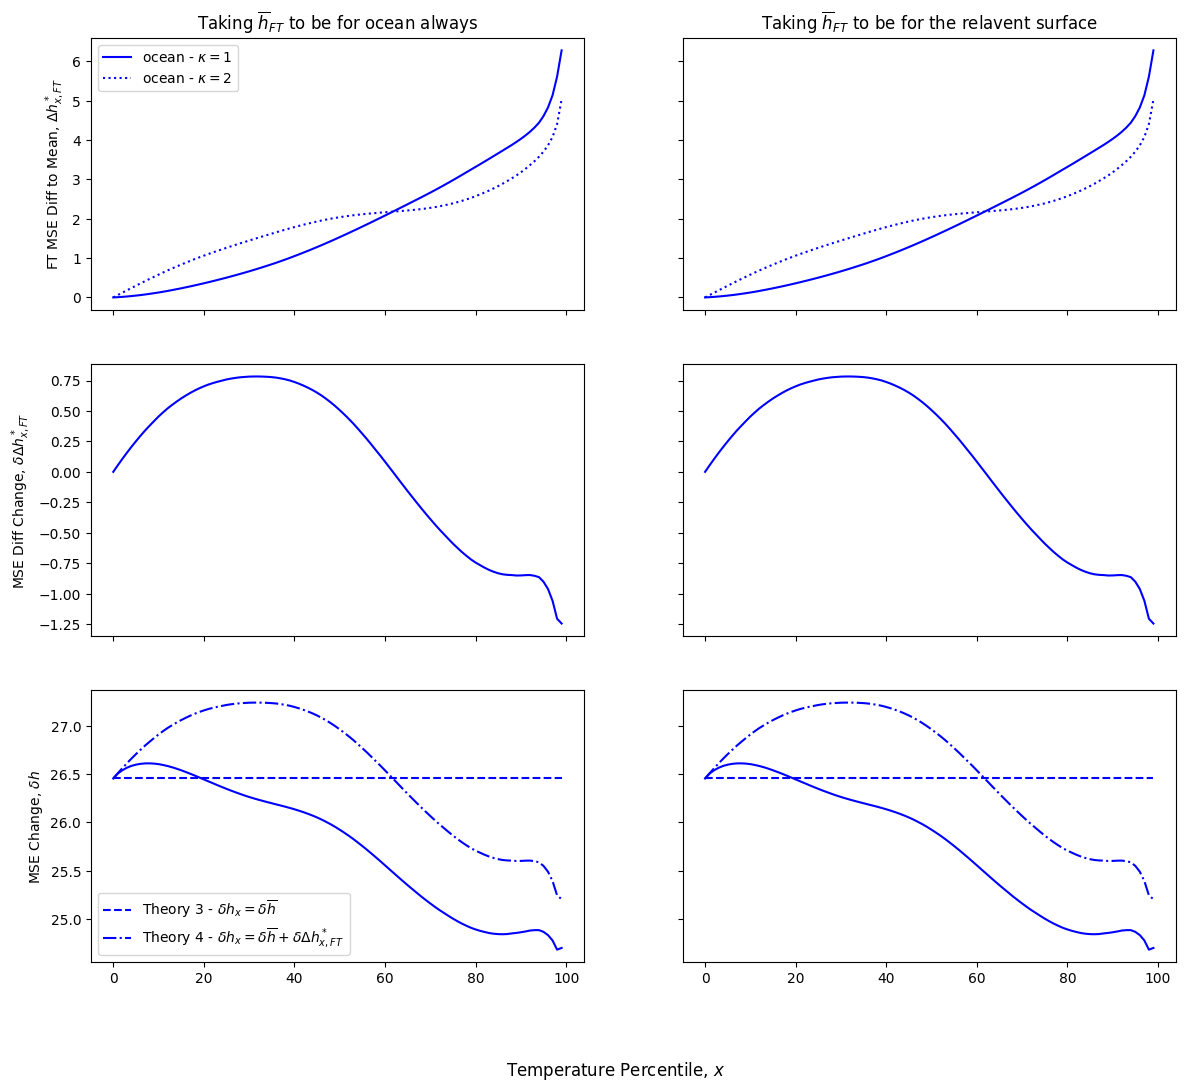

In [71]:
mse_ft_diff1 = {}        # uses ocean as mean
mse_ft_diff2 = {}        # uses relavent surface as mean
fig, ax = plt.subplots(3,2, figsize=(14, 12), sharex=True, sharey='row')
for surf in surfaces:
    mse_ft_diff1[surf] = np.asarray([mse_ft_sat[surf][i]-mse_ft_sat['ocean'][i][0] for i in range(n_exp)])
    mse_ft_diff2[surf] = np.asarray([mse_ft_sat[surf][i]-mse_ft_sat[surf][i][0] for i in range(n_exp)])
    ax[0,0].plot(quant_plot, mse_ft_diff1[surf][0], color=plt_color[surf], label=f'{surf} - $\kappa={tau_lw_ref}$')
    ax[0,0].plot(quant_plot, mse_ft_diff1[surf][1], color=plt_color[surf],
                 linestyle=':', label=f'{surf} - $\kappa={tau_lw_warm}$')
    ax[0,1].plot(quant_plot, mse_ft_diff2[surf][0], color=plt_color[surf], label=f'{surf} - $\kappa={tau_lw_ref}$')
    ax[0,1].plot(quant_plot, mse_ft_diff2[surf][1], color=plt_color[surf],
                 linestyle=':', label=f'{surf} - $\kappa={tau_lw_warm}$')

    ax[1,0].plot(quant_plot, mse_ft_diff1[surf][1] - mse_ft_diff1[surf][0], color=plt_color[surf])
    ax[1,1].plot(quant_plot, mse_ft_diff2[surf][1] - mse_ft_diff2[surf][0], color=plt_color[surf])

    ax[2,0].plot(quant_plot, mse[surf][1] - mse[surf][0], color=plt_color[surf])
    if surf == 'ocean':
        label1 = 'Theory 3 - $\delta h_x = \delta \overline{h}$'
        label2 = 'Theory 4 - $\delta h_x = \delta \overline{h} + \delta \Delta h^*_{x,FT}$'
    else:
        label1 = None
        label2 = None
    ax[2,0].plot(quant_plot, (mse['ocean'][1] - mse['ocean'][0])[0] * np.ones_like(quant_plot), color=plt_color[surf],
                 linestyle='--', label=label1)
    ax[2,0].plot(quant_plot, (mse['ocean'][1] - mse['ocean'][0])[0] + mse_ft_diff1[surf][1] - mse_ft_diff1[surf][0],
                 color=plt_color[surf], linestyle='-.', label=label2)
    ax[2,1].plot(quant_plot,  mse[surf][1] - mse[surf][0], color=plt_color[surf])
    ax[2,1].plot(quant_plot, (mse[surf][1] - mse[surf][0])[0] * np.ones_like(quant_plot), color=plt_color[surf], linestyle='--')
    ax[2,1].plot(quant_plot, (mse[surf][1] - mse[surf][0])[0] + mse_ft_diff2[surf][1] - mse_ft_diff2[surf][0],
                 color=plt_color[surf], linestyle='-.')
#ax.plot(quant_plot, mse['ocean'][1]-mse['ocean'][0], color='blue', label='Simulated $\delta h_x$')
# ax.plot(lat_centre, mse_quant_diff_sim, color='k', linestyle='--', label='Theory $\delta h_x$')
# ax.plot(lat_centre, mse_summer_diff, color='r', linestyle=':', label='Mean, $\delta \overline{h}$')
fig.supxlabel('Temperature Percentile, $x$')
ax[0,0].set_ylabel('FT MSE Diff to Mean, $\Delta h^*_{x,FT}$')
ax[1,0].set_ylabel('MSE Diff Change, $\delta \Delta h^*_{x,FT}$')
ax[2,0].set_ylabel(f'MSE Change, $\delta h$')
ax[0,0].set_title('Taking $\overline{h}_{FT}$ to be for ocean always')
ax[0,1].set_title('Taking $\overline{h}_{FT}$ to be for the relavent surface')
ax[0,0].legend()
ax[2, 0].legend();

In [72]:
def get_temp_theory_gamma(temp_x, sphum_x, delta_rh_x, temp_mean, sphum_mean, delta_rh_mean):
    # All input variables are at the lower reference kappa simulation
    # Outputs factors used in the theoretical predictions for changes in temperature
    denom = c_p + L_v * clausius_clapeyron_factor(temp_x) * (sphum_x + sphum_sat(temp_x, p_surface) * delta_rh_x)
    gamma_t = c_p + L_v * clausius_clapeyron_factor(temp_mean) * (sphum_mean + sphum_sat(temp_mean, p_surface) * delta_rh_mean)
    gamma_t = gamma_t / denom
    gamma_r_mean = L_v * sphum_sat(temp_mean, p_surface) / denom
    gamma_r_quant = -L_v * sphum_sat(temp_x, p_surface) / denom
    gamma_z_diff = g / denom
    gamma_mse_diff = 1/denom
    return gamma_t, gamma_r_mean, gamma_r_quant, gamma_z_diff, gamma_mse_diff

rh_quant = {surf: np.asarray([rh_from_sphum(sphum_quant[surf][i],temp_quant[surf][i],p_surface)/100 for i in range(n_exp)])
            for surf in surfaces}
rh_mean = {surf: np.asarray([rh_from_sphum(sphum_quant[surf][i][0],temp_quant[surf][i][0],p_surface)/100 for i in range(n_exp)])
           for surf in surfaces}


# Version to use with mse_ft_diff1 as always uses ocean as the mean
gamma = {surf: get_temp_theory_gamma(temp_quant[surf][0], sphum_quant[surf][0], rh_quant[surf][1] - rh_quant[surf][0],
                                     temp_mean['ocean'][0], sphum_quant['ocean'][0][0], rh_mean['ocean'][1] - rh_mean['ocean'][0])
         for surf in surfaces}

# Version to use with mse_ft_diff2
# gamma2 = {surf: get_temp_theory_gamma(temp_quant[surf][0], sphum_quant[surf][0], rh_quant[surf][1] - rh_quant[surf][0],
#                                       temp_mean[surf][0], sphum_quant[surf][0][0], rh_mean[surf][1] - rh_mean[surf][0])
#           for surf in surfaces}

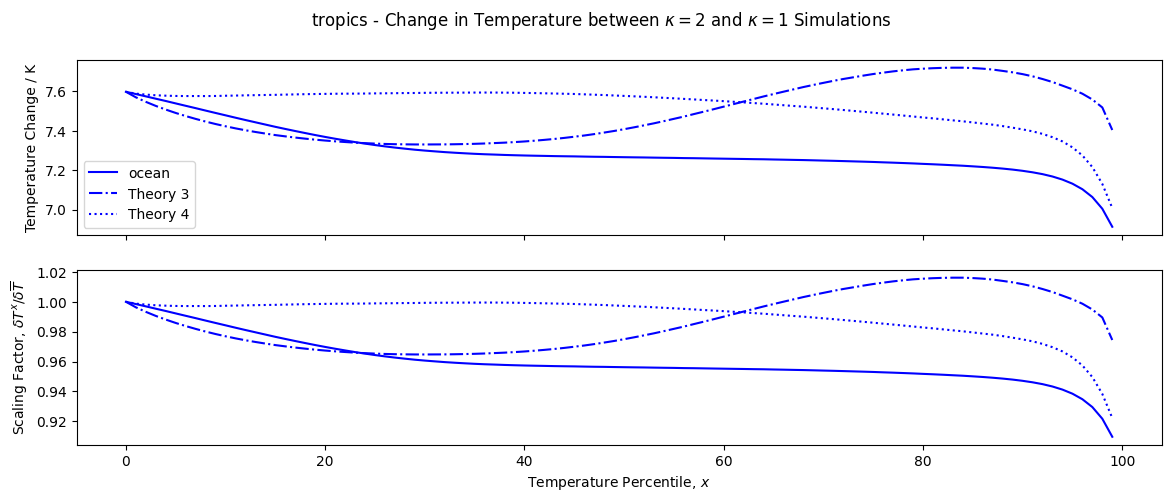

In [73]:
# Need to multiply MSE contribution by 1000 to put MSE in units of J/kg rather than kJ/kg
# For mean, use 'ocean' because always consider the ocean mean the mean value
# Leave out tiny Delta Z contribution
temp_theory_cont = {surf: np.asarray([gamma[surf][0] * (temp_mean['ocean'][1] - temp_mean['ocean'][0]),
                                      gamma[surf][1] * (rh_mean['ocean'][1] - rh_mean['ocean'][0]),
                                      gamma[surf][2] * (rh_quant[surf][1] - rh_quant[surf][0]),
                                      gamma[surf][4] * 1000 * (mse_ft_diff1[surf][1] - mse_ft_diff1[surf][0])])
                    for surf in surfaces}
# Version to use with gamma2 and mse_ft_diff2
# temp_theory_cont = {surf: np.asarray([gamma2[surf][0] * (temp_mean[surf][1] - temp_mean[surf][0]),
#                                       gamma2[surf][1] * (rh_mean[surf][1] - rh_mean[surf][0]),
#                                       gamma2[surf][2] * (rh_quant[surf][1] - rh_quant[surf][0]),
#                                       gamma2[surf][4] * 1000 * (mse_ft_diff2[surf][1] - mse_ft_diff2[surf][0])])
#                     for surf in surfaces}
temp_cont_labels = ['$\delta \overline{T}$', '$\delta \overline{r}$', '$\delta r_x$', '$\delta \Delta h^*_{x,FT}$']

fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
for surf in ['ocean']:
    temp_diff_quant = temp_quant[surf][1]-temp_quant[surf][0]
    temp_diff_mean = temp_mean[surf][1]-temp_mean[surf][0]
    ax[0].plot(quant_plot, temp_diff_quant, label=surf, color=plt_color[surf])
    if surf == 'ocean':
        label1 = 'Theory 3'
        label2 = 'Theory 4'
    else:
        label1 = None
        label2 = None
    ax[0].plot(quant_plot, np.sum(temp_theory_cont[surf][:3], axis=0), label=label1, color=plt_color[surf], linestyle='-.')
    ax[0].plot(quant_plot, np.sum(temp_theory_cont[surf][:4], axis=0), label=label2, color=plt_color[surf], linestyle=':')
    ax[1].plot(quant_plot, temp_diff_quant/temp_diff_mean, label=surf, color=plt_color[surf])
    ax[1].plot(quant_plot, np.sum(temp_theory_cont[surf][:3], axis=0)/temp_diff_mean, label=surf, color=plt_color[surf], linestyle='-.')
    ax[1].plot(quant_plot, np.sum(temp_theory_cont[surf][:4], axis=0)/temp_diff_mean, label=surf, color=plt_color[surf], linestyle=':')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].legend()
plt.suptitle(f"{region} - Change in Temperature between $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations");

### Theory Temperature Contributions
The plots below show that for land, there is a much larger contribution to the theory from change in relative humidity than for ocean.

Also the $\gamma^T$ decreases for the largest $x$ which is the opposite of what is shown in byrne 2021.


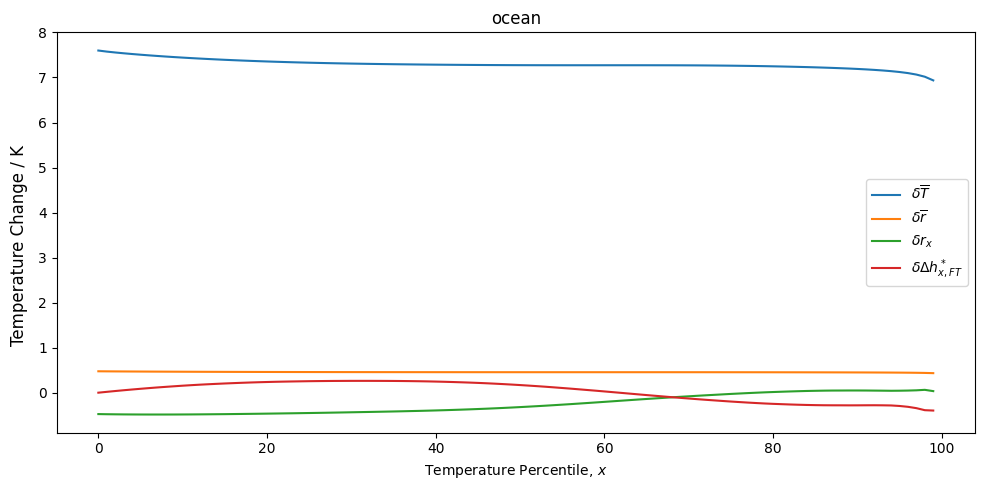

In [75]:
fig, ax = plt.subplots(n_surf,1, figsize=(10, 5))
for k, surf in enumerate(surfaces):
    for i in range(len(temp_theory_cont[surf])):
        ax.plot(quant_plot, temp_theory_cont[surf][i], label=temp_cont_labels[i])
        ax.set_title(surf)
ax.legend()
ax.set_xlabel('Temperature Percentile, $x$')
fig.supylabel('Temperature Change / K')
plt.tight_layout();

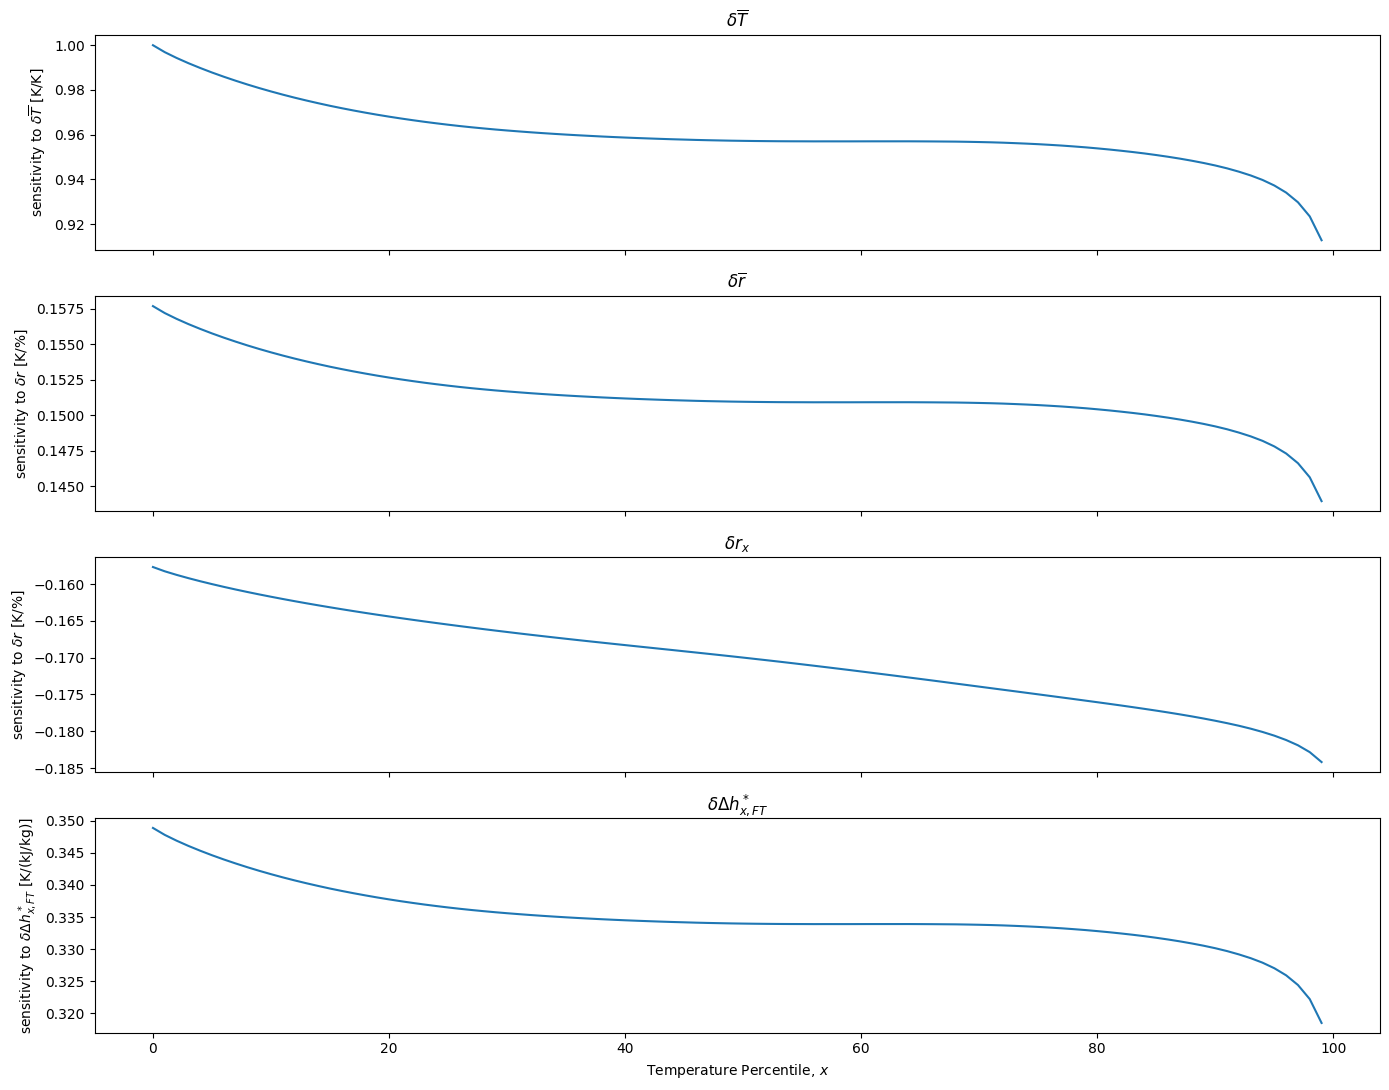

In [76]:
# Plot gamma values
fig, ax = plt.subplots(len(temp_cont_labels),1, figsize=(14, 11), sharex=True)
j = 0
for i in [0, 1, 2, 4]:
    if i == 1 or i == 2:
        ax[j].plot(quant_plot, gamma['ocean'][i] / 100, label=temp_cont_labels[j])
        ax[j].set_ylabel('sensitivity to $\delta r$ [K/%]')
    elif i == 4:
        ax[j].plot(quant_plot, gamma['ocean'][i] * 1000, label=temp_cont_labels[j])
        ax[j].set_ylabel('sensitivity to $\delta \Delta h^*_{x,FT}$ [K/(kJ/kg)]')
    else:
        ax[j].plot(quant_plot, gamma['ocean'][i], label=temp_cont_labels[j])
        ax[j].set_ylabel('sensitivity to $\delta \overline{T}$ [K/K]')
    ax[j].set_title(temp_cont_labels[j])
    j += 1
ax[-1].set_xlabel('Temperature Percentile, $x$')
plt.tight_layout();

## Condition for hottest days warming more than the mean
As from the above plots, the $\overline{T}$ contribution is dominant so to get the $x$ percentile day to warm more than the mean, it is required that $\gamma^T>1$.

For this to happen, we require the relative humidity in the reference climate be below a threshold:
$$
r_x < \frac{\bar{\alpha} \bar{q}^*(\overline{r} + \delta \overline{r})}{\alpha_x q_x^*} - \delta r_x
$$

With the inclusion of the $\delta \overline{r}$ and $\delta r_x$, this requires knowledge of the future climate, so we also plot the threshold relative humidity if we assume these are 0 i.e. constant relative humidity.

For the extratropics, it is clear that the relative humidity is always above the threshold and this difference increases with $x$, hence the temperature change decreases with $x$.

In the tropics, $r_x$ is approximately constant as $x$ varies and always above the most accurate threshold (solid black line), hence the temperature change is less than the mean.

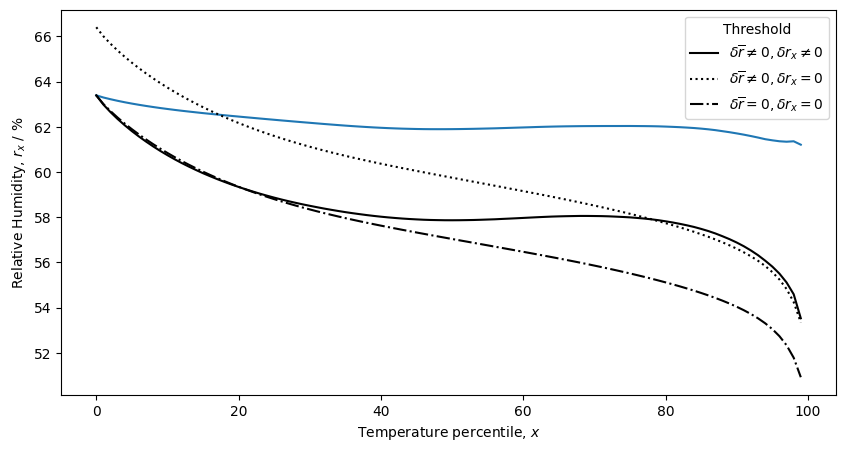

In [77]:
def thresh_rh(temp_bar, rh_bar, temp_x, delta_rh_bar=0, delta_rh_x=0):
    # bar means mean and x means percentile.
    # returns threshold relative humidity, below which get temp increase greater than mean
    return clausius_clapeyron_factor(temp_bar) * sphum_sat(temp_bar, p_surface) * (rh_bar + delta_rh_bar) / \
        (clausius_clapeyron_factor(temp_x) * sphum_sat(temp_x, p_surface)) - delta_rh_x

thresh_rh1 = thresh_rh(temp_mean['ocean'][0], rh_mean['ocean'][0], temp_quant['ocean'][0],
                       rh_mean['ocean'][1] - rh_mean['ocean'][0], rh_quant['ocean'][1] - rh_quant['ocean'][0])
thresh_rh2 = thresh_rh(temp_mean['ocean'][0], rh_mean['ocean'][0], temp_quant['ocean'][0],
                       rh_mean['ocean'][1] - rh_mean['ocean'][0])
thresh_rh3 = thresh_rh(temp_mean['ocean'][0], rh_mean['ocean'][0], temp_quant['ocean'][0])

fig, ax = plt.subplots(n_surf,1, figsize=(10, 5))
ax.plot(quant_plot, 100*rh_quant['ocean'][0])
ax.plot(quant_plot, 100*thresh_rh1, linestyle='-', color='k', label='$\delta \overline{r} \\neq 0, \delta r_x \\neq 0$')
ax.plot(quant_plot, 100*thresh_rh2, linestyle=':', color='k', label='$\delta \overline{r} \\neq 0, \delta r_x = 0$')
ax.plot(quant_plot, 100*thresh_rh3, linestyle='-.', color='k', label='$\delta \overline{r} = 0, \delta r_x = 0$')
ax.legend(title='Threshold')
ax.set_ylabel('Relative Humidity, $r_x$ / %')
ax.set_xlabel('Temperature percentile, $x$');